In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

In [2]:
# Load Data
def load_imu_data(file):
    df = pd.read_csv(file)
    df['Time(s)'] = df['Time(ms)'] / 1000  # Convert ms to seconds
    return df

# Apply a Butterworth filter to smooth gyroscope data
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)

# Integrate GyroZ to get segment angles
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.diff(time, prepend=time[0]))  # Numerical Integration
    return angle - np.mean(angle[:50]) + initial_angle  # Drift Correction

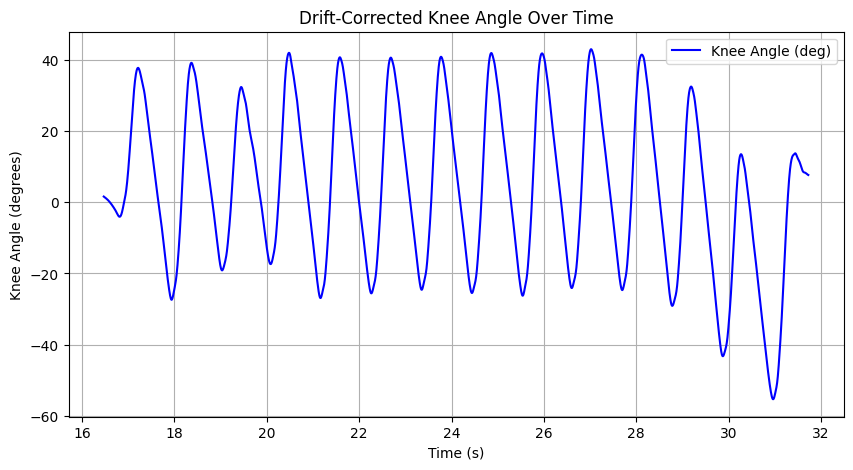

In [10]:
# Load IMU data
thigh_file = "./dataset_formatted/patient1/test5/LT.csv"  # Left Thigh
shank_file = "./dataset_formatted/patient1/test5/LS.csv"  # Left Shank

thigh_data = load_imu_data(thigh_file)
shank_data = load_imu_data(shank_file)

# Apply a high-pass filter to remove low-frequency drift
def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return signal.filtfilt(b, a, data)

fs = 100  # Sampling Frequency

# Corrected angle calculation with drift removal
thigh_data["GyroZ_filtered"] = butter_lowpass_filter(thigh_data["GyroZ"], fs=fs)
shank_data["GyroZ_filtered"] = butter_lowpass_filter(shank_data["GyroZ"], fs=fs)

# Apply high-pass filter to remove drift
thigh_data["GyroZ_filtered"] = high_pass_filter(thigh_data["GyroZ_filtered"], fs=fs)
shank_data["GyroZ_filtered"] = high_pass_filter(shank_data["GyroZ_filtered"], fs=fs)

# Integrate gyro data
thigh_data["Angle"] = integrate_gyro(thigh_data["GyroZ_filtered"], thigh_data["Time(s)"])
shank_data["Angle"] = integrate_gyro(shank_data["GyroZ_filtered"], shank_data["Time(s)"])

# Compute knee joint angle
knee_angle = thigh_data["Angle"] - shank_data["Angle"]

# Plot the corrected knee angle
plt.figure(figsize=(10, 5))
plt.plot(thigh_data["Time(s)"], knee_angle, label="Knee Angle (deg)", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Knee Angle (degrees)")
plt.title("Drift-Corrected Knee Angle Over Time")
plt.legend()
plt.grid()
plt.show()



# Compute knee joint angle
knee_angle = thigh_data["Angle"] - shank_data["Angle"]

In [11]:
print(thigh_data["Angle"])

0       1.036293
1       0.984919
2       0.941663
3       0.897976
4       0.853874
          ...   
3046    6.864445
3047    6.834796
3048    6.808872
3049    6.786933
3050    6.769087
Name: Angle, Length: 3051, dtype: float64


In [12]:
print(shank_data["Angle"])

0      -0.574170
1      -0.568211
2      -0.562111
3      -0.555858
4      -0.549434
          ...   
3046   -0.954369
3047   -0.936950
3048   -0.921572
3049   -0.908667
3050   -0.898517
Name: Angle, Length: 3051, dtype: float64


In [13]:
print(knee_angle)

0       1.610463
1       1.553131
2       1.503774
3       1.453834
4       1.403308
          ...   
3046    7.818815
3047    7.771746
3048    7.730445
3049    7.695600
3050    7.667604
Name: Angle, Length: 3051, dtype: float64


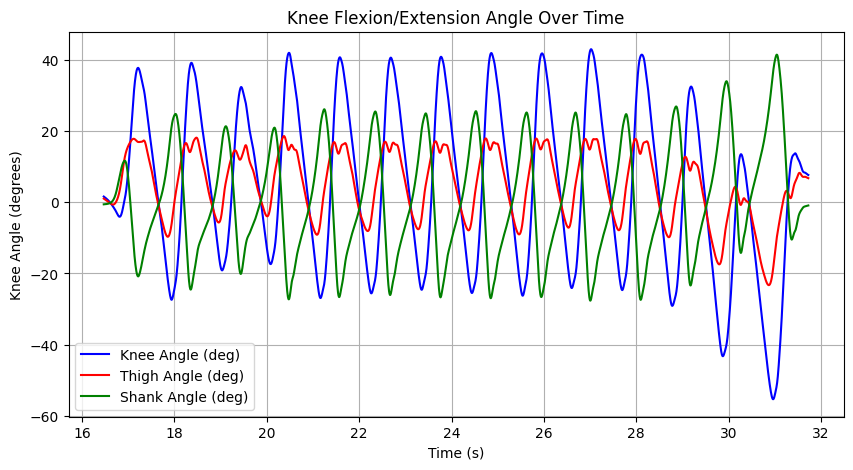

In [15]:
# Plot knee angle over time
plt.figure(figsize=(10, 5))
plt.plot(thigh_data["Time(s)"], knee_angle, label="Knee Angle (deg)", color='b')
plt.plot(thigh_data["Time(s)"], thigh_data["Angle"], label="Thigh Angle (deg)", color='r')
plt.plot(thigh_data["Time(s)"], shank_data["Angle"], label="Shank Angle (deg)", color='g')
plt.xlabel("Time (s)")
plt.ylabel("Knee Angle (degrees)")
plt.title("Knee Flexion/Extension Angle Over Time")
plt.legend()
plt.grid()
plt.show()
